##THis notebook is for trying to create cell images from existing nuclei images of same cells  due to data missing

### The task is Image to Image translation 

## This code is run and evaluated on high content cell imaging dataset

### First thing is to add libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob



#### At first try we trained a simple U-shape model which the input is nuclei images and output is cell images
#### The original data is in 1104x1104 format and the model input is 256x256. 
#### We needed to extract patches first and feed patches to model
#### This is the simplest form of U-Net model for image to image translation

## The following code is for visual evaluation of trained Unet.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 128, 128, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 128)  73856       ['conv2d_7[0][0]']               
                                                                                            

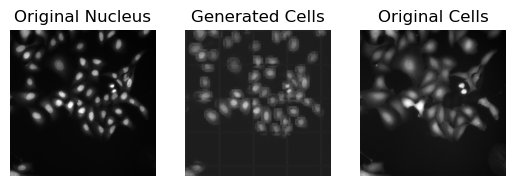

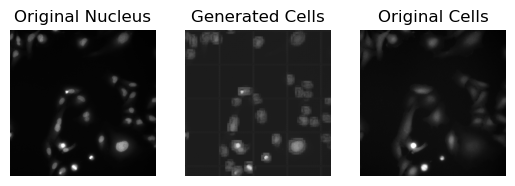

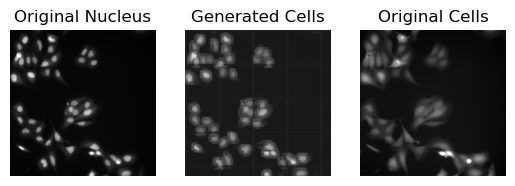

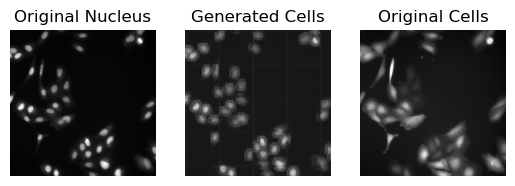

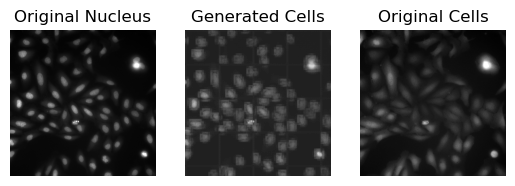

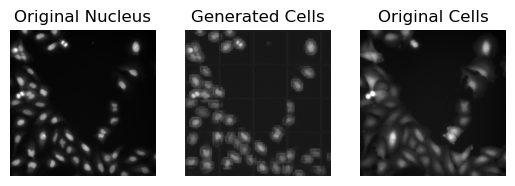

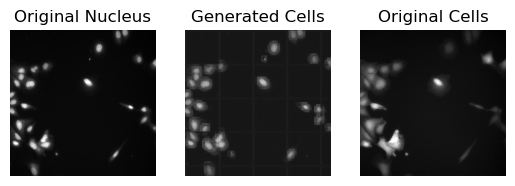

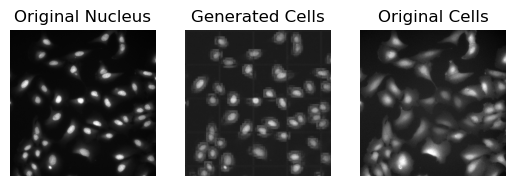

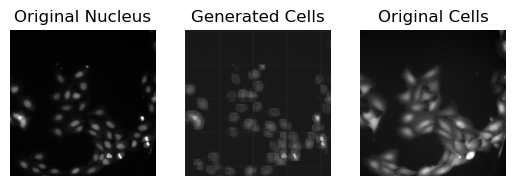

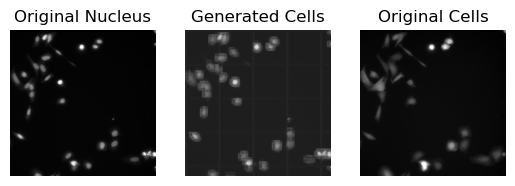

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import UNet
from skimage import img_as_float32, img_as_ubyte


# Load the saved model
generator = UNet.unet_model(output_channels=1)

# Load the weights from the checkpoint file
model_path = "../models/UNet/Unet_gray_final_generator.h5"  # Example path to the checkpoint file
generator.load_weights(model_path)

def normalize(image):
    # Normalize image
    percentile = 99.9
    high = np.percentile(image,percentile)
    low = np.percentile(image,100-percentile)
    
    img = np.minimum(high, image)
    img = np.maximum(low, img)
    img = (img-low)/(high-low)
    img = img_as_ubyte(img)
    return img

# Function to load and preprocess an image
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [1104, 1104])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width, _ = image.shape

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator, input_image, patch_size=256, step=256):
    input_patches, positions = extract_patches(input_image, patch_size, step)
    generated_patches = generator.predict(input_patches)
    
    output_image = reassemble_patches(generated_patches, positions, input_image.shape, patch_size, step)
    return output_image

# Load validation images
val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')

print('Herereeeeeeeee')
for img in val_nuclei_dir:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    input_image = input_image / 255.0  # Normalize to [0, 1]

    input_image = np.expand_dims(input_image, axis=-1)
    
    predicted_image = predict_full_image(generator, input_image)
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')

    output_image_path = '../results/UNet/' + os.path.basename(img)
    cv2.imwrite(output_image_path, normalize((predicted_image * 255).astype(np.uint8)))
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(img).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/UNet/'+os.path.basename(img).replace('.png', '_prediction.png'))
    

In [60]:
## For imroving Unet model, we have changed unet architecture (make it deeper) and also loss function

Herereeeeeeeee


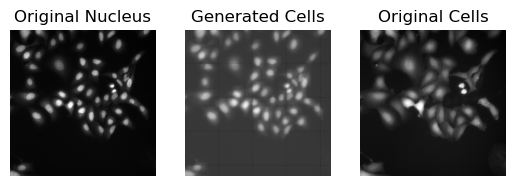

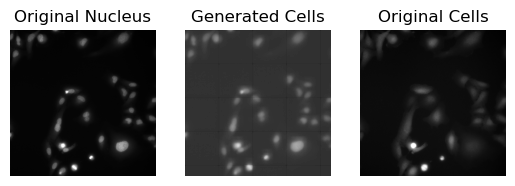

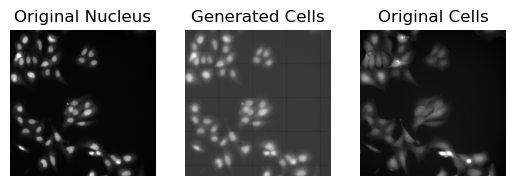

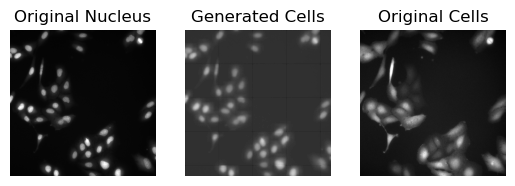

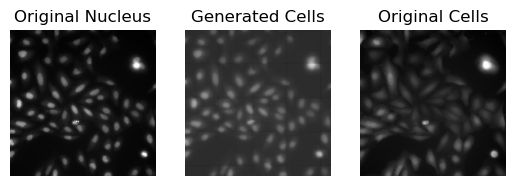

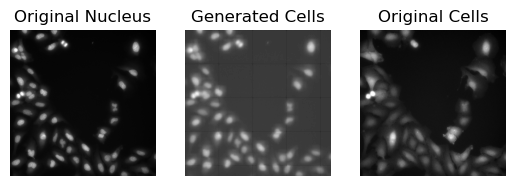

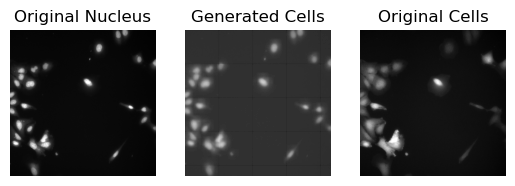

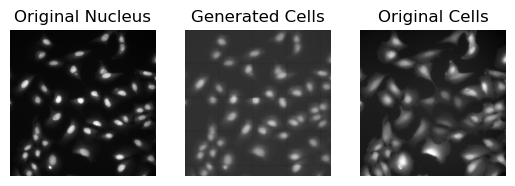

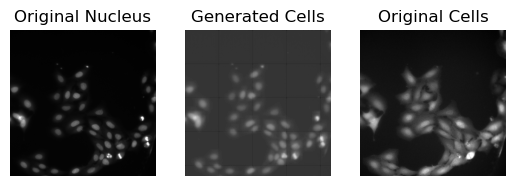

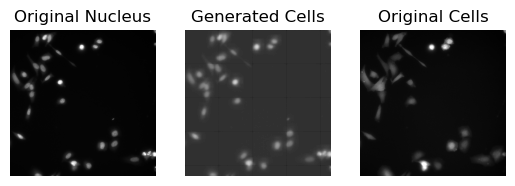

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import glob
import Improved_UNet
import Preprocessing
import skimage
from skimage import img_as_float32, img_as_ubyte


# Load the saved model
generator = Improved_UNet.unet_model(output_channels=1)

# Load the weights from the checkpoint file
model_path = "../models/UNet_LR/UNet_LR_gray_final_generator.h5"
generator.load_weights(model_path)


def normalize(image):
    # Normalize image
    percentile = 99.9
    high = np.percentile(image,percentile)
    low = np.percentile(image,100-percentile)
    
    img = np.minimum(high, image)
    img = np.maximum(low, img)
    img = (img-low)/(high-low)
    img = img_as_ubyte(img)
    return img

# Function to load and preprocess an image
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)  # Load as 1 channel (grayscale)
    image = tf.image.resize(image, [1104, 1104])
    image = tf.cast(image, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
    return image

def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width = image.shape[:2]  # Extract height and width only

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            # Ensure the patch is within image bounds
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)  # 1 channel
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator, input_image, patch_size=256, step=256):
    input_patches, positions = extract_patches(input_image, patch_size, step)
    generated_patches = generator.predict(input_patches)
    # Rescale to [0, 1]
    generated_patches = (generated_patches + 1) / 2.0
    
    output_image = reassemble_patches(generated_patches, positions, input_image.shape, patch_size, step)
    return output_image

# Load validation images
val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')

print('Herereeeeeeeee')
for img in val_nuclei_dir:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    input_image = input_image / 255.0  # Normalize to [0, 1]

    input_image = np.expand_dims(input_image, axis=-1)
    
    predicted_image = predict_full_image(generator, input_image)
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')

    output_image_path = '../results/UNet_LR/' + os.path.basename(img)
    cv2.imwrite(output_image_path, normalize((predicted_image * 255).astype(np.uint8)))
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(img).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/UNet_LR/'+os.path.basename(img).replace('.png', '_prediction.png'))
    


In [ ]:
### After UNets we moved on with GANs, a generator and a discriminator
### We started from a simple GAN and we imrproved both model (deeper model) and noise and latent vector added to input image

### The following code is for prediction od 

In [ ]:
##improve GAN

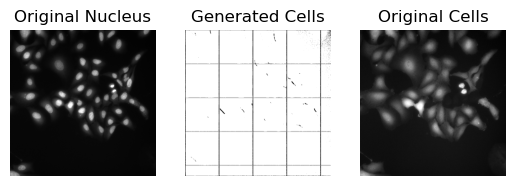

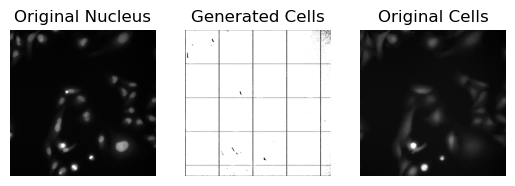

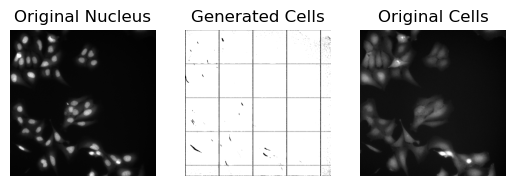

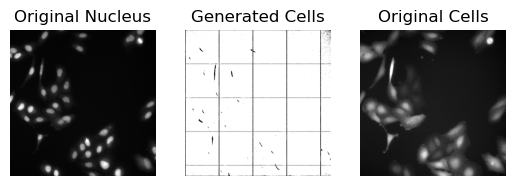

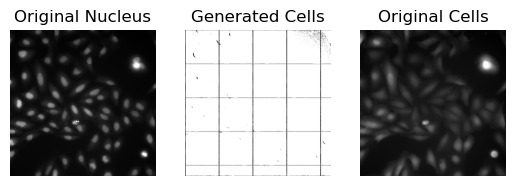

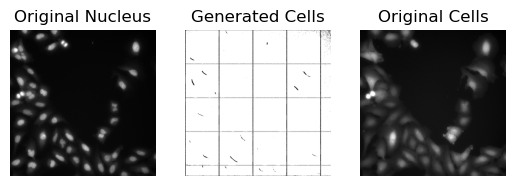

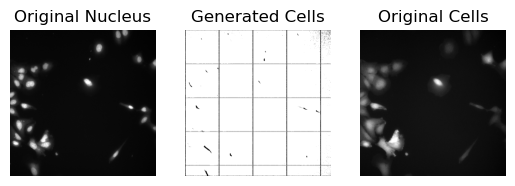

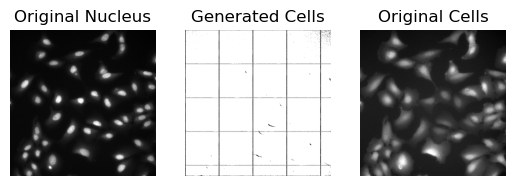

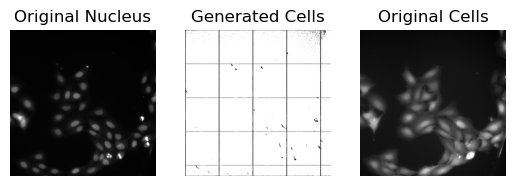

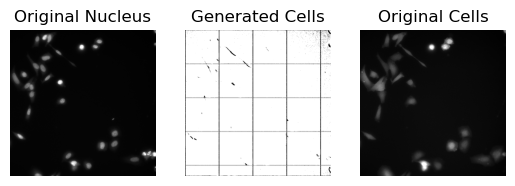

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import GAN
import Preprocessing_GAN
import glob
import os

generator = GAN.build_generator()
discriminator = GAN.build_discriminator()
gan = GAN.build_gan(generator,discriminator,)

# Load the weights from the checkpoint file
model_path = "../models/GAN/generator_final.h5"
generator.load_weights(model_path)


def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width, _ = image.shape

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            # Ensure the patch is within image bounds
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator, input_image, patch_size=256, step=256):
    input_patches, positions = extract_patches(input_image, patch_size, step)
    
    noise = np.random.normal(0, 1, input_patches.shape)

    generated_patches = generator.predict([input_patches,noise])
   
 
    # Generate patches with the trained generator

    #generated_patches = (generated_patches + 1) / 2.0  # Rescale to [0, 1]   
    output_image = reassemble_patches(generated_patches, positions, input_image.shape, patch_size, step)
    return output_image

val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')


for img in val_nuclei_dir:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    input_image = normalize(input_image) # Normalize to [0, 1]
    input_image = np.expand_dims(input_image, axis=-1)
    
    predicted_image = predict_full_image(generator, input_image)
    
    plt.subplot(1, 3, 2)
    plt.imshow((predicted_image).astype(np.uint8), cmap='gray')
    
    plt.axis('off')
    plt.title('Generated Cells')

    output_image_path = '../results/GAN/' + os.path.basename(img)
    cv2.imwrite(output_image_path, ((predicted_image )))
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(img).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/GAN/'+os.path.basename(img).replace('.png', '_prediction.png'))
  
    



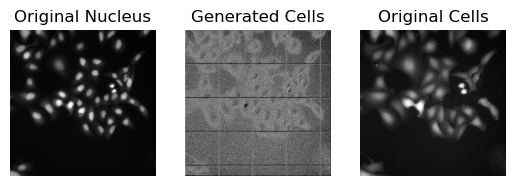

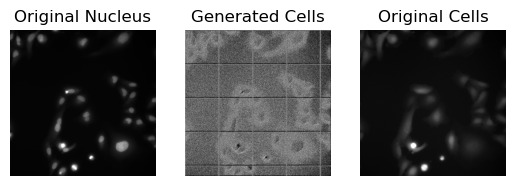

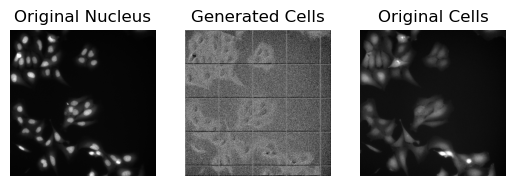

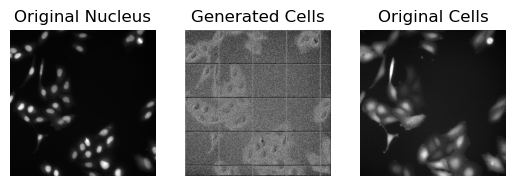

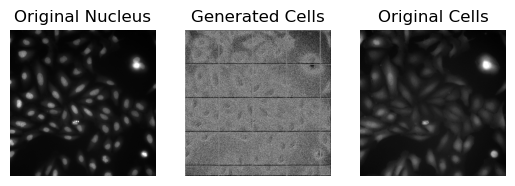

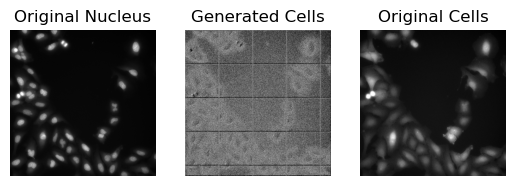

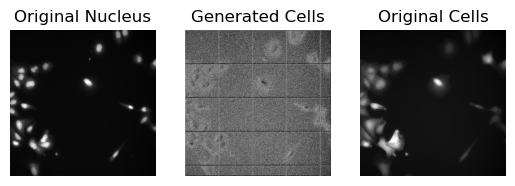

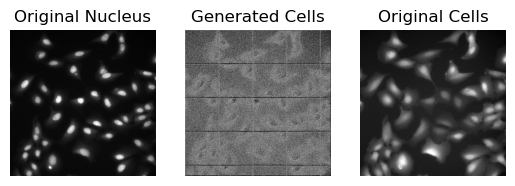

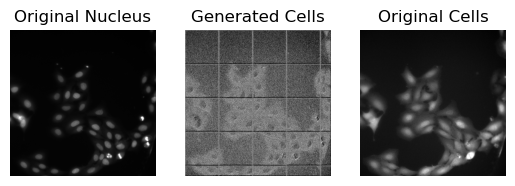

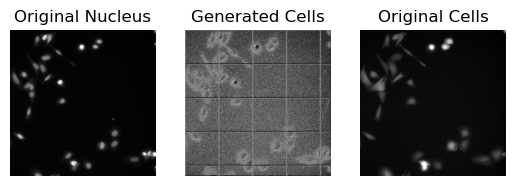

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import GAN_combined_loss
import Preprocessing_GAN



generator = GAN_combined_loss.build_generator()
discriminator = GAN_combined_loss.build_discriminator()
gan = GAN_combined_loss.build_gan(generator,discriminator)

# Load the weights from the checkpoint file

model_path = "../models/GAN_combined_loss/improved_GAN_combined_loss_generator_final.h5"
generator.load_weights(model_path)


def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width, _ = image.shape

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            # Ensure the patch is within image bounds
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator, input_image, patch_size=256, step=256):
    input_patches, positions = extract_patches(input_image, patch_size, step)
    
    noise = np.random.normal(0, 1, input_patches.shape)

    generated_patches = generator.predict([input_patches,noise])
 
 
    # Generate patches with the trained generator

    generated_patches = (generated_patches + 1) / 2.0  # Rescale to [0, 1]   
    output_image = reassemble_patches(generated_patches, positions, input_image.shape, patch_size, step)
    return output_image

val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')


for img in val_nuclei_dir:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    input_image = input_image  # Normalize to [0, 1]
   
 
    input_image = np.expand_dims(input_image, axis=-1)
    
    predicted_image = predict_full_image(generator, input_image)
 
    
    plt.subplot(1, 3, 2)
    plt.imshow(normalize(predicted_image.squeeze()), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')

    output_image_path = '../results/GAN_combined_loss/' + os.path.basename(img)
    cv2.imwrite(output_image_path, normalize(predicted_image))
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(img).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/GAN_combined_loss/'+os.path.basename(img).replace('.png', '_prediction.png'))
    





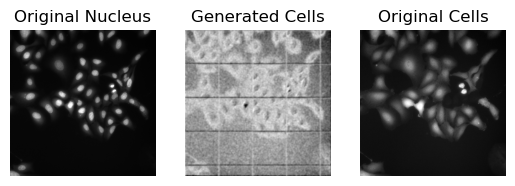

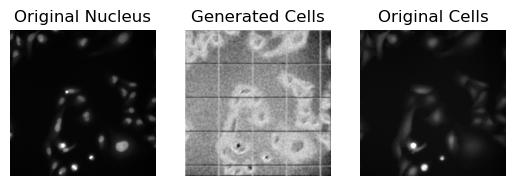

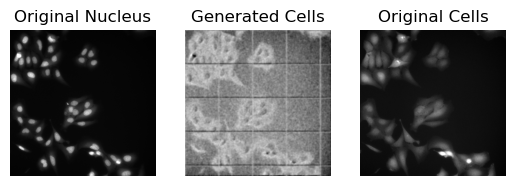

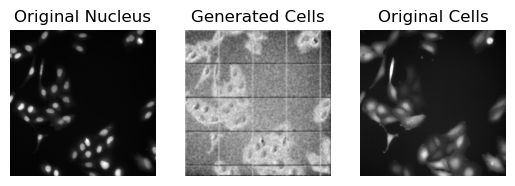

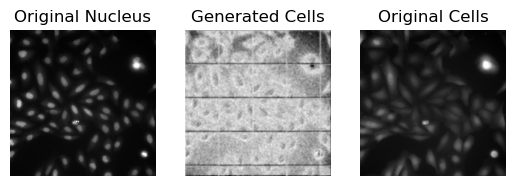

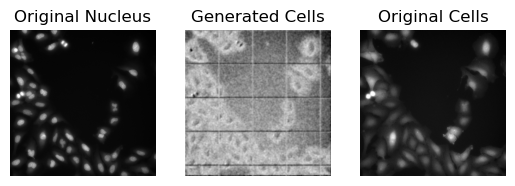

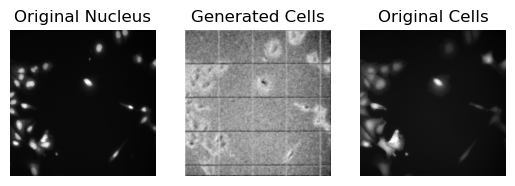

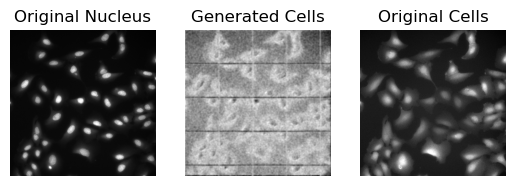

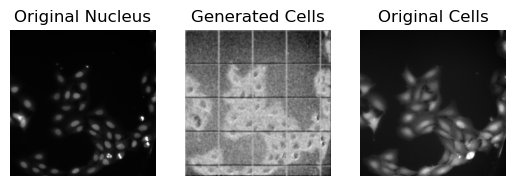

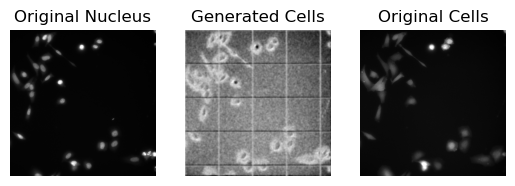

In [59]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import GAN_combined_loss
import Preprocessing_GAN



generator = GAN_combined_loss.build_generator()
discriminator = GAN_combined_loss.build_discriminator()
gan = GAN_combined_loss.build_gan(generator,discriminator)

# Load the weights from the checkpoint file

model_path = "../models/GAN_combined_loss/improved_GAN_combined_loss_generator_final.h5"
generator.load_weights(model_path)



# Post-processing
def post_process_image(image):
    processed_image = cv2.GaussianBlur(image, (25,25), 0)
    return processed_image


# Function to predict the full image
def predict_full_image(generator, input_image, patch_size=256):
    h, w, _ = input_image.shape
    output_image = np.zeros((h, w, 1))
    noise = np.random.normal(0, 1, (patch_size, patch_size, 1))

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            input_patch = input_image[i:i+patch_size, j:j+patch_size, :]
            if input_patch.shape[0] < patch_size or input_patch.shape[1] < patch_size:
                continue
            input_patch = np.expand_dims(input_patch, axis=0)
            noise_patch = np.expand_dims(noise, axis=0)
            generated_patch = generator.predict([input_patch, noise_patch])
            output_image[i:i+patch_size, j:j+patch_size, :] = generated_patch[0]

    return output_image


def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width, _ = image.shape

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            # Ensure the patch is within image bounds
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator, input_image, patch_size=256, step=256):
    # Extract patches from the input image
    input_patches, positions = extract_patches(input_image, patch_size, step)
    
    # Generate noise for each patch
    noise = np.random.normal(0, 1, input_patches.shape)
    
    # Generate patches with the trained generator
    generated_patches = generator.predict([input_patches, noise])
    generated_patches = (generated_patches + 1) / 2.0  # Rescale to [0, 1]
    
    # Reassemble patches into the full-size image
    output_image = reassemble_patches(generated_patches, positions, input_image.shape, patch_size, step)
    return output_image
val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')


for img in val_nuclei_dir:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    input_image = input_image  # Normalize to [0, 1]
   
 
    input_image = np.expand_dims(input_image, axis=-1)
    
    predicted_image = predict_full_image(generator, input_image)
    predicted_image = post_process_image(predicted_image)
   
    plt.subplot(1, 3, 2)
    plt.imshow(((predicted_image.squeeze())*2-1), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')

    
    output_image_path = '../results/GAN_combined_loss_improved_noise/' + os.path.basename(img)
    cv2.imwrite(output_image_path, ((predicted_image-np.min(predicted_image))/(np.max(predicted_image)-np.min(predicted_image)))*255)
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(img).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/GAN_combined_loss_improved_noise/'+os.path.basename(img).replace('.png', '_prediction.png'))
    




In [ ]:
### Here we have trained Generator as well
## train generator as well

Model: "model_220"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_370 (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 dense_97 (Dense)               (None, 65536)        6619136     ['input_370[0][0]']              
                                                                                                  
 input_369 (InputLayer)         [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 reshape_23 (Reshape)           (None, 256, 256, 1)  0           ['dense_97[0][0]']       

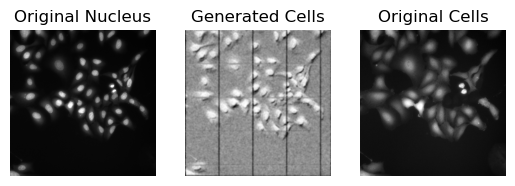

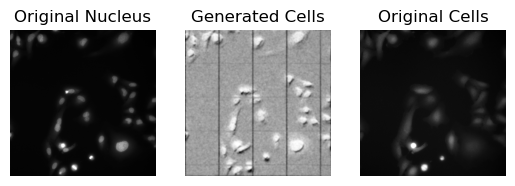

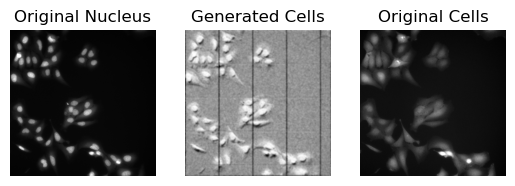

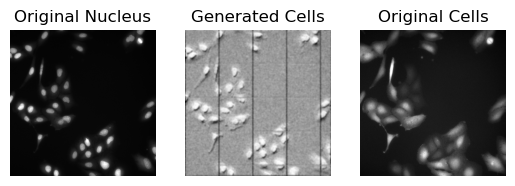

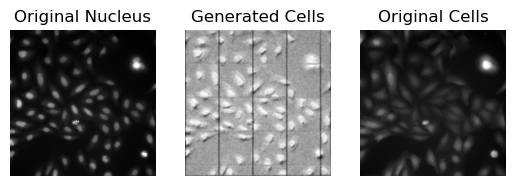

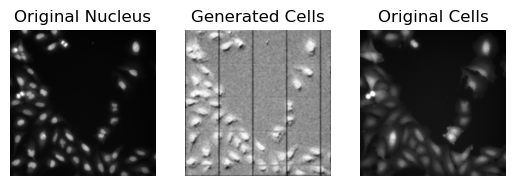

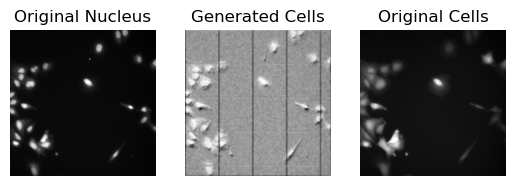

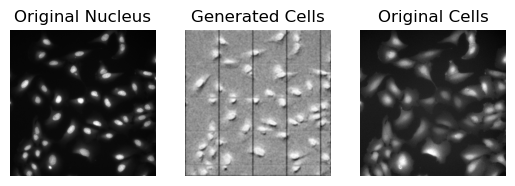

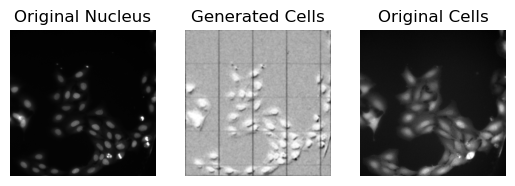

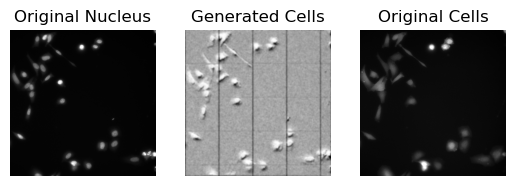

In [84]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import GAN_latent_space
import Preprocessing_GAN



generator = GAN_latent_space.build_generator(latent_dim=100)
discriminator = GAN_latent_space.build_discriminator()
gan = GAN_latent_space.build_gan(generator,discriminator)

# Load the weights from the checkpoint file

model_path = "../models/GAN_latent_space/improved_GAN_latent_space_generator_final.h5"
generator.load_weights(model_path)



# Post-processing
def post_process_image(image):
    processed_image = cv2.GaussianBlur(image, (25,25), 0)
    return processed_image


def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width, _ = image.shape

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            # Ensure the patch is within image bounds
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator, input_image, patch_size=256, step=256,  latent_dim=100):
    # Extract patches from the input image
    input_patches, positions = extract_patches(input_image, patch_size, step)
  
    # Generate noise for each patch
    batch_latent = np.random.normal(0, 1, (25, latent_dim))
    
   
    
    # Generate patches with the trained generator
    generated_patches = generator.predict([input_patches, batch_latent])
    generated_patches = (generated_patches + 1) / 2.0
    
    # Combine the generated patches into a full image
    generated_image = reassemble_patches(generated_patches, positions,input_image.shape, patch_size, step)
    
    return generated_image
val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')


for img in val_nuclei_dir:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    input_image = input_image  # Normalize to [0, 1]
   
 
    input_image = np.expand_dims(input_image, axis=-1)
    
    predicted_image = predict_full_image(generator, input_image)
    predicted_image = post_process_image(predicted_image)

    x=1-((predicted_image.squeeze())*2-1)
    plt.subplot(1, 3, 2)
    plt.imshow(1-((predicted_image.squeeze())*2-1)-np.min(x), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')
    
    print(np.max(1-((predicted_image.squeeze())*2-1)-np.min(x)))
    
    output_image_path = '../results/GAN_latent_space/' + os.path.basename(img)
    cv2.imwrite(output_image_path, 255-((predicted_image-np.min(predicted_image))/(np.max(predicted_image)-np.min(predicted_image)))*255)
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(img).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/GAN_latent_space/'+os.path.basename(img).replace('.png', '_prediction.png'))
    




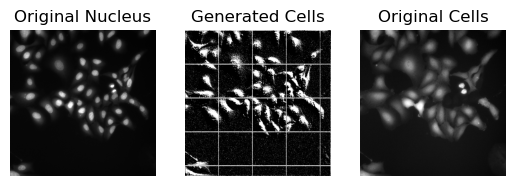

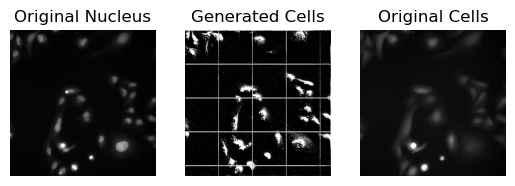

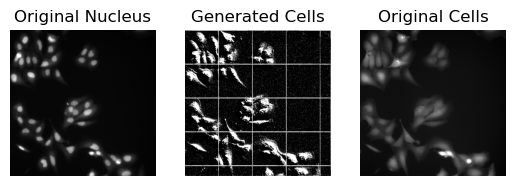

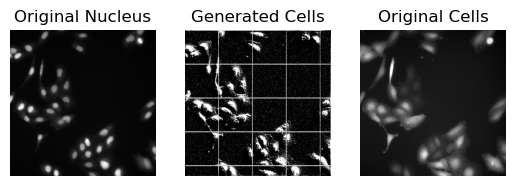

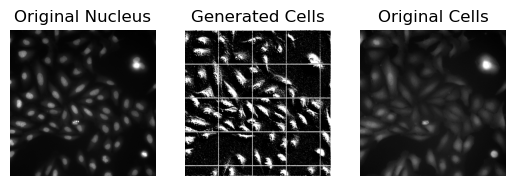

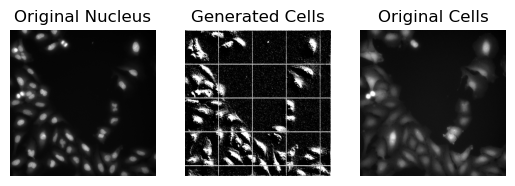

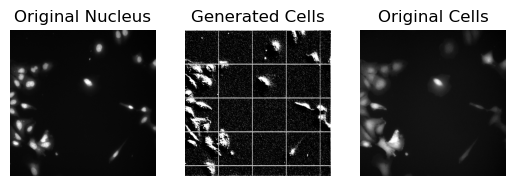

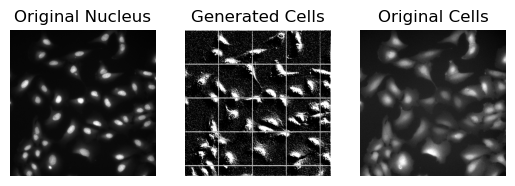

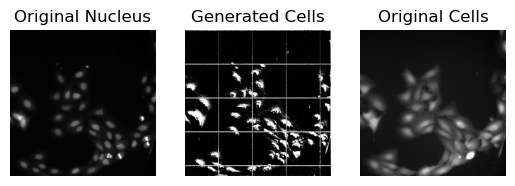

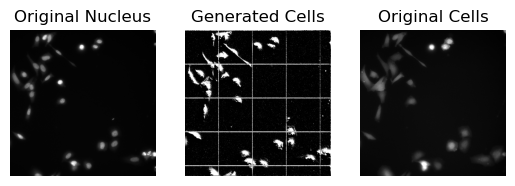

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import GAN_improved_latent_space
import Preprocessing_GAN



generator = GAN_improved_latent_space.build_generator()
discriminator = GAN_improved_latent_space.build_discriminator()
gan = GAN_improved_latent_space.build_gan(generator,discriminator)

# Load the weights from the checkpoint file

model_path = "../models/GAN_improved_latent_space/GAN_improved_latent_space_generator_final.h5"
generator.load_weights(model_path)



# Post-processing
def post_process_image(image):
    processed_image = cv2.GaussianBlur(image, (25,25), 0)
    return processed_image


def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width, _ = image.shape

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            # Ensure the patch is within image bounds
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator, input_image, patch_size=256, step=256,  latent_dim=100):
    # Extract patches from the input image
    input_patches, positions = extract_patches(input_image, patch_size, step)
  
    # Generate noise for each patch
    batch_latent = np.random.uniform(0, 1, (25,256,256,1))
    
   
    
    # Generate patches with the trained generator
    generated_patches = generator.predict([input_patches, batch_latent])
    generated_patches = (generated_patches + 1) / 2.0
    
    # Combine the generated patches into a full image
    generated_image = reassemble_patches(generated_patches, positions,input_image.shape, patch_size, step)
    
    return generated_image
val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')


for img in val_nuclei_dir:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    input_image = input_image  # Normalize to [0, 1]
   
 
    input_image = np.expand_dims(input_image, axis=-1)
    
    predicted_image = predict_full_image(generator, input_image)
    #predicted_image = post_process_image(predicted_image)

    x=1-((predicted_image.squeeze())*2-1)
    plt.subplot(1, 3, 2)
    plt.imshow(((predicted_image.squeeze())*2-1), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')
    
    
    
    output_image_path = '../results/GAN_improved_latent_space/' + os.path.basename(img)
    cv2.imwrite(output_image_path, ((predicted_image-np.min(predicted_image))/(np.max(predicted_image)-np.min(predicted_image)))*255)
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(img).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/GAN_improved_latent_space/'+os.path.basename(img).replace('.png', '_prediction.png'))
    




## The next thing we tried was to add segmentation masks as latent space to generator. so the input were nulcei, cells and cell masks as latent space

uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


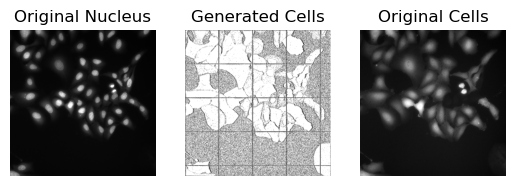

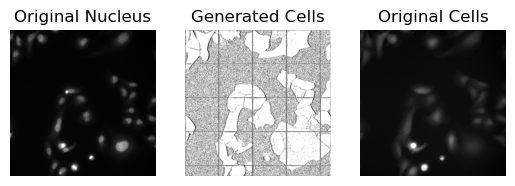

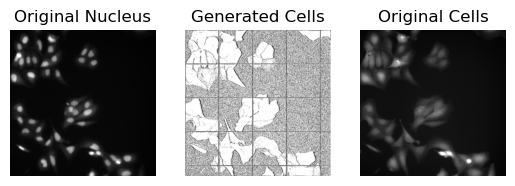

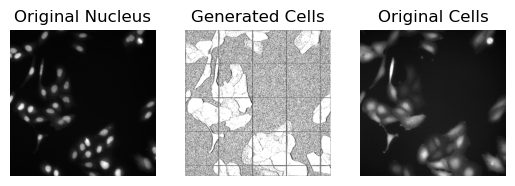

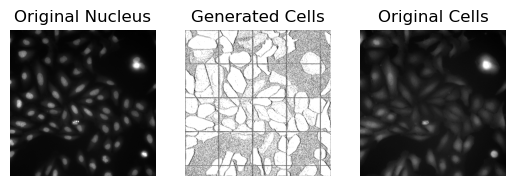

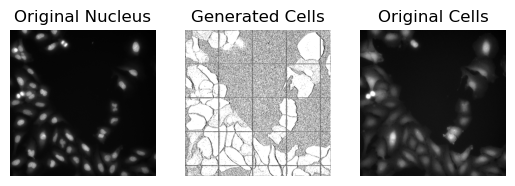

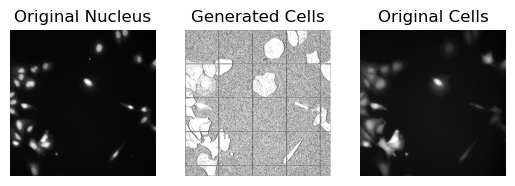

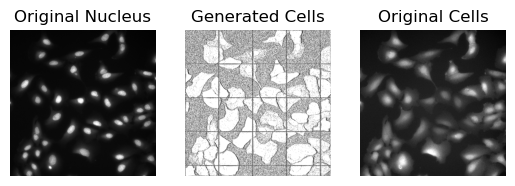

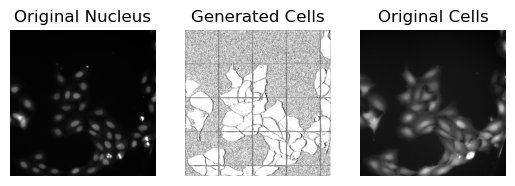

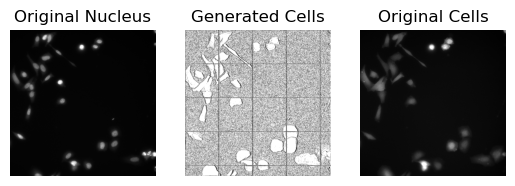

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import GAN_improved_latent_space
import Preprocessing_GAN
import os


generator = GAN_improved_latent_space.build_generator()
discriminator = GAN_improved_latent_space.build_discriminator()
gan = GAN_improved_latent_space.build_gan(generator,discriminator)

# Load the weights from the checkpoint file

model_path = "../models/GAN_mask_latent_space/improved_GAN_mask_latent_space_generator_epoch_80_g_loss_0.6724890470504761.h5"
generator.load_weights(model_path)


# Post-processing
def post_process_image(image):
    processed_image = cv2.GaussianBlur(image, (25,25), 0)
    return processed_image


def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width,_ = image.shape

    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            # Ensure the patch is within image bounds
            patch = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            patch[:min(patch_size, img_height - i), :min(patch_size, img_width - j)] = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float32)
    patch_count = np.zeros(img_shape, dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image

def predict_full_image(generator,input_image,mask_image ,patch_size=256, step=256,  latent_dim=100):
    # Extract patches from the input image
    print(input_image.dtype)
    input_patches, positions = extract_patches(input_image, patch_size, step)
   
    # Generate noise for each patch
    batch_latent, positions_ = extract_patches(mask_image,patch_size,step)
  
   
    
    # Generate patches with the trained generator
    generated_patches = generator.predict([input_patches, batch_latent])
    generated_patches = (generated_patches + 1) / 2.0
    
    # Combine the generated patches into a full image
    generated_image = reassemble_patches(generated_patches, positions,input_image.shape, patch_size, step)
    
    return generated_image
val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')
val_mask_dir = glob.glob('../data/6_val_annot/cell/*.png')


  
for (nuclei_img_path, mask_img_path) in zip(val_nuclei_dir, val_mask_dir):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(nuclei_img_path), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(nuclei_img_path, cv2.IMREAD_GRAYSCALE)    
    input_image = input_image  # Normalize to [0, 1]
    input_image = np.expand_dims(input_image, axis=-1)
    input_mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
    input_mask = input_mask  # Normalize to [0, 1]
    input_mask = np.expand_dims(input_mask, axis=-1)
    
    
    predicted_image = predict_full_image(generator, input_image, input_mask)

    x=1-((predicted_image.squeeze())*2-1)
    plt.subplot(1, 3, 2)
    plt.imshow(((predicted_image.squeeze())*2-1), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')
    
    
    output_image_path = '../results/GAN_mask_latent_space/' + os.path.basename(nuclei_img_path)
    cv2.imwrite(output_image_path, ((predicted_image-np.min(predicted_image))/(np.max(predicted_image)-np.min(predicted_image)))*255)
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(nuclei_img_path).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/GAN_mask_latent_space/'+os.path.basename(nuclei_img_path).replace('.png', '_prediction.png'))
    






## moved to diffusion model 

Model: "model_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_161 (InputLayer)      [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_180 (Conv2D)         (None, 256, 256, 64)      640       
                                                                 
 conv2d_181 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_182 (Conv2D)         (None, 64, 64, 256)       295168    
                                                                 
 conv2d_183 (Conv2D)         (None, 32, 32, 512)       1180160   
                                                                 
Total params: 1,549,824
Trainable params: 1,549,824
Non-trainable params: 0
_________________________________________________________________
Model: "model_118"
____________________________

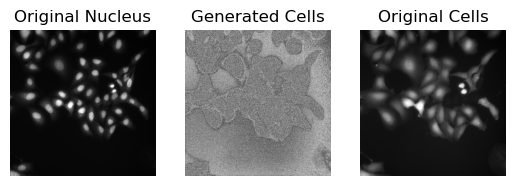

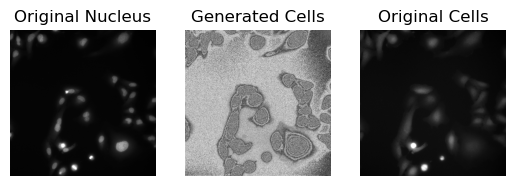

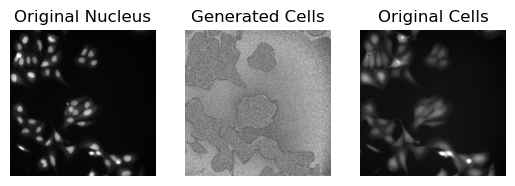

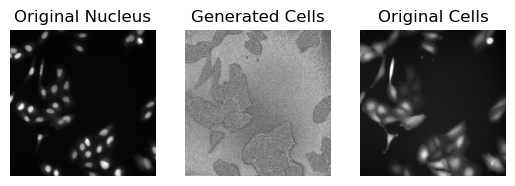

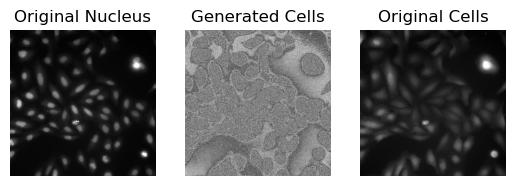

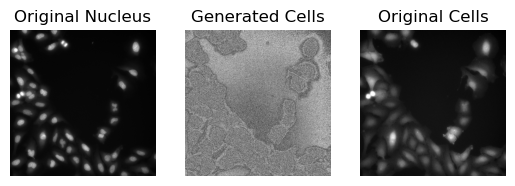

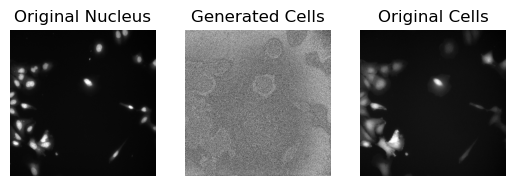

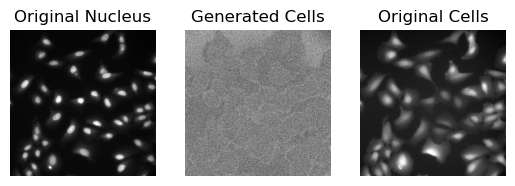

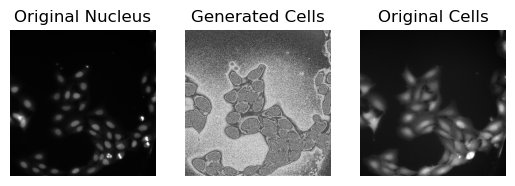

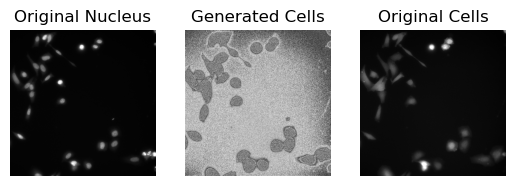

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import Diffusion
import Preprocessing_GAN
import glob

encoder = Diffusion.build_encoder()
decoder = Diffusion.build_decoder()
diffusion_model = Diffusion.build_diffusion_model(encoder, decoder)

# Load the weights from the checkpoint file

model_path = "../models/Diffusion_model/diffusion_model_final.h5"
diffusion_model.load_weights(model_path)

diffusion_model.summary()

# Post-processing
def post_process_image(image):
    processed_image = cv2.GaussianBlur(image, (25,25), 0)
    return processed_image


import numpy as np


def extract_patches(image, patch_size=256, step=256):
    patches = []
    positions = []
    img_height, img_width,_ = image.shape


  

    # If patch_size is a tuple, unpack it; otherwise, use it as both height and width
    
    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
          
            # Ensure the patch is within image bounds
            patch = np.zeros((256,256, 1),dtype=np.float32)
            patch[:min(256, img_height - i), :min(256, img_width - j)] = image[i:i+256, j:j+256]
            patches.append(patch)
            positions.append((i, j))
           
    return np.array(patches), positions

    return patches
def reassemble_patches(patches, positions, img_shape, patch_size=256, step=256):
    reconstructed_image = np.zeros(img_shape, dtype=np.float64)
    patch_count = np.zeros(img_shape, dtype=np.float64)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch[:img_shape[0]-i, :img_shape[1]-j]
        patch_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero and normalize
    reconstructed_image /= np.maximum(patch_count, 1)
    return reconstructed_image



def predict_full_image(generator,  input_image, mask_image, patch_size=(256, 256), step=128, latent_dim=256):
    patches, positions       = extract_patches(input_image, patch_size, step)
    batch_latent, positions_ = extract_patches(mask_image, patch_size, step)

    # Generate patches with the trained generator

    t = np.linspace(0, 1,10)
    x_noisy = patches
    for ti in reversed(t):
        noise_pred = generator.predict([x_noisy, batch_latent])
        beta_t = Diffusion.noise_schedule(ti)
        x_noisy = (x_noisy - np.sqrt(beta_t) * noise_pred) / np.sqrt(1 - beta_t)
    #x_noisy = x_noisy.numpy()  # Convert to NumPy array
    x_noisy = (x_noisy * 127.5 + 127.5).astype(np.uint8)

    generated_patches = x_noisy
    generated_patches = (generated_patches + 1) / 2.0

    # Combine the generated patches into a full image
    generated_image = reassemble_patches(generated_patches, positions,input_image.shape, 256, step)

    return generated_image




val_nuclei_dir = glob.glob('../data/5_Val/nuclei/*.png')
val_cell_dir = glob.glob('../data/5_Val/cell/*.png')
val_mask_dir = glob.glob('../data/6_val_annot/cell/*.png')


  
for (nuclei_img_path, mask_img_path) in zip(val_nuclei_dir, val_mask_dir):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(nuclei_img_path), cmap='gray')
    plt.axis('off')
    plt.title('Original Nucleus')

    input_image = cv2.imread(nuclei_img_path, cv2.IMREAD_GRAYSCALE)    
    input_image = input_image  # Normalize to [0, 1]
    input_image = np.expand_dims(input_image, axis=-1)
    
    input_mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
    input_mask = input_mask  # Normalize to [0, 1]
    input_mask = np.expand_dims(input_mask, axis=-1)
    
   
    predicted_image = predict_full_image(diffusion_model, input_image, input_mask)
    
    x=1-((predicted_image.squeeze())*2-1)
    plt.subplot(1, 3, 2)
    plt.imshow(1-((predicted_image.squeeze())*2-1), cmap='gray')
    plt.axis('off')
    plt.title('Generated Cells')
    
    
    output_image_path = '../results/Diffusion_model/' + os.path.basename(nuclei_img_path)
    cv2.imwrite(output_image_path, 255-((predicted_image-np.min(predicted_image))/(np.max(predicted_image)-np.min(predicted_image)))*255)
    
    plt.subplot(1, 3, 3)
    ground_truth_img = cv2.imread('../data/5_Val/cell/' + os.path.basename(nuclei_img_path).replace('d0', 'd1'), cv2.IMREAD_GRAYSCALE)
   
    plt.imshow(ground_truth_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Cells')
    plt.savefig('../results/Diffusion_model/'+os.path.basename(nuclei_img_path).replace('.png', '_prediction.png'))
    






